In [30]:
# from quippy.potential import Potential
# from mace.calculators import MACECalculator
import pyjulip
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import pyjulip
from random import sample
import os
import time
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5


def get_RMSE(model,ref):
    N=len(model)
    num = (ref-model)**2
    return np.sqrt(sum(num)/N)

e0={'Al':-107.1308,'Ti':-1587.0235,'V':-2065.7874}

# 1686220958

## set calc and training data

In [31]:
data=ase.io.read('data_and_benchmarks/ti64_combined_data_Apr08.extxyz', index=':')
# data=ase.io.read('data_and_benchmarks/ti64_combined_data_May30.extxyz', index=':') #includes phonon target data.



print(len(data))
samples = sample(range(len(data)),len(data)) # can sub sample here, if needed.
print(len(samples))




ace_potential="/home/physics/phspnt/project_work/julia_testing/ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json"
#Set calc variable as your ASE calculator
calc=pyjulip.ACE1(ace_potential)
calcstr = ace_potential.split('/')[-1] #set a label.
### GAPcalc=True enables a parallel pool (makes gap faster), doesn't work with ACE. Keep False to be safe, but True might speed things up.
GAPcalc=False


# ### FINE TUNED MACE
# from mace.calculators import MACECalculator
# calc = MACECalculator(model_paths=f'/home/physics/phspnt/project_work/local_castep/ti64/MACE_model/MACE_freeze4_small_20_swa.model', device='cpu')
# calcstr = 'MACE_freeze4_small_20_swa.json'
# GAPcalc=True





#############################
#############################
#############################
print(calcstr)
RMSEname=f'RMSE_all_{calcstr}'
print(RMSEname)
benchmarks_RMSE_all={}

8507
8507
ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json
RMSE_all_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json


### Run training data RMSE

In [32]:
start = time.time()
nodes=20

QM_E = []
QM_forces=[]
QM_forces_flat=np.array([])
QM_virial=[]
GAP_E=[]
GAP_forces=[]
GAP_forces_flat=np.array([])
GAP_virial=[]
labels=[]
# GAP="gapfits/run000/ti64_cd_jan30.xml"



# ace_potential = '/home/physics/phspnt/project_work/julia_testing/Ti_combined_oct24_2023_data_ace_order_3_degree_20_rcut_6.0_cw_moreV.json'
# calc=pyjulip.ACE1(ace_potential)


string = f"frames_{len(samples)}_" + calcstr

### for ACE evaluations
def calculate_all(s):
    cs = data[s].get_chemical_symbols()
    counts = [cs.count(('Ti')), cs.count(('Al')), cs.count(('V'))]
    isolated_energy = counts[0]*e0['Ti'] + counts[1]*e0['Al'] + counts[2]*e0['V']
    qm_e = (data[s].info['QM_energy']- isolated_energy)/len(data[s])
    qm_forces= data[s].arrays['QM_forces'].flatten()
    qm_virial= data[s].info['QM_virial']/len(data[s])
    data[s].calc = calc
    gap_e = (data[s].get_potential_energy()-isolated_energy)/len(data[s])
    gap_forces = data[s].get_forces().flatten()
    gap_virial = -data[s].get_stress(voigt=False).flatten()*data[s].get_volume()/len(data[s])
    l = data[s].info['config_type']
    return qm_e, qm_forces, qm_virial, gap_e, gap_forces, gap_virial, l



if GAPcalc==True:
### USE FOR GAP (PARALLEL, does not work with ACE)
    with ProcessPoolExecutor(max_workers=nodes) as executor:
        for result in executor.map(calculate_all, samples):
            QM_E.append(result[0])
            QM_virial.append(result[2])
            QM_forces_flat=np.append(QM_forces_flat,result[1])
            GAP_E.append(result[3])
            GAP_forces_flat = np.append(GAP_forces_flat,result[4])
            GAP_virial.append(result[5])
            labels.append(result[6])
else:
###Serial for ACE
    for s in samples:
        result = calculate_all(s)
        QM_E.append(result[0])
        QM_virial.append(result[2])
        QM_forces_flat=np.append(QM_forces_flat,result[1])
        GAP_E.append(result[3])
        GAP_forces_flat = np.append(GAP_forces_flat,result[4])
        GAP_virial.append(result[5])
        labels.append(result[6])



QM_E = np.array(QM_E)
QM_virial = np.array(QM_virial)

GAP_E = np.array(GAP_E)
GAP_virial = np.array(GAP_virial)


#writing out RMSE since it's expense to keep.
dictionary={}
dictionary['GAP_E'] = GAP_E.tolist()
dictionary['GAP_F'] = GAP_forces_flat.tolist()
dictionary['GAP_V'] = GAP_virial.tolist()
dictionary['QM_E'] = QM_E.tolist()
dictionary['QM_F'] = QM_forces_flat.tolist()
dictionary['QM_V'] = QM_virial.tolist()
dictionary['labels'] = labels


import json

loc=f"RMSE_benchmarks/{string}"
with open(loc, 'w') as f:
    json.dump(dictionary, f)

print(string)


end = time.time()
print("time:",end - start, ' s')



frames_8507_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json
time: 276.54548811912537  s


In [33]:
### Read training data RMSE
import json
import codecs


obj_text = codecs.open(loc, 'r', encoding='utf-8').read()
b_new = json.loads(obj_text)

calc_E= np.array(b_new["GAP_E"], dtype=float)
calc_forces_flat= np.array(b_new["GAP_F"])
calc_virial= np.array(b_new["GAP_V"])

QM_E= np.array(b_new["QM_E"], dtype=float)
QM_forces_flat= np.array(b_new["QM_F"])
QM_virial= np.array(b_new["QM_V"])
labels = b_new['labels']


benchmarks_RMSE_all['E_train (eV)'] = get_RMSE(GAP_E,QM_E)
benchmarks_RMSE_all['F_train (eV/AA)'] = get_RMSE(calc_forces_flat,QM_forces_flat)
benchmarks_RMSE_all['V_train (eV)'] = get_RMSE(GAP_virial.flatten(),QM_virial.flatten())

### validation set

In [34]:
validation_frames=ase.io.read('data_and_benchmarks/validation_frames.extxyz', index=':'); print(len(validation_frames))

start = time.time()

nodes=4

QM_E = []
QM_forces=[]
QM_forces_flat=np.array([])
QM_virial=[]
GAP_E=[]
GAP_forces=[]
GAP_forces_flat=np.array([])
GAP_virial=[]
labels=[]

string = f"validation_set_" + calcstr


def calculate_all(s):
    cs = validation_frames[s].get_chemical_symbols()
    counts = [cs.count(('Ti')), cs.count(('Al')), cs.count(('V'))]
    isolated_energy = counts[0]*e0['Ti'] + counts[1]*e0['Al'] + counts[2]*e0['V']
    qm_e = (validation_frames[s].info['QM_energy']- isolated_energy)/len(validation_frames[s])
    qm_forces= validation_frames[s].arrays['QM_forces'].flatten()
    qm_virial= validation_frames[s].info['QM_virial']/len(validation_frames[s])
    validation_frames[s].calc = calc
    gap_e = (validation_frames[s].get_potential_energy()-isolated_energy)/len(validation_frames[s])
    gap_forces = validation_frames[s].get_forces().flatten()
    gap_virial = -validation_frames[s].get_stress(voigt=False).flatten()*validation_frames[s].get_volume()/len(validation_frames[s])
    l = validation_frames[s].info['config_type']
    return qm_e, qm_forces, qm_virial, gap_e, gap_forces, gap_virial, l

if GAPcalc==True:
    with ProcessPoolExecutor(max_workers=nodes) as executor:
        for result in executor.map(calculate_all, range(len(validation_frames))):
            QM_E.append(result[0])
            QM_virial.append(result[2])
            QM_forces_flat=np.append(QM_forces_flat,result[1])
            GAP_E.append(result[3])
            GAP_forces_flat = np.append(GAP_forces_flat,result[4])
            GAP_virial.append(result[5])
            labels.append(result[6])

else:
    for s in range(len(validation_frames)):
        result = calculate_all(s)
        QM_E.append(result[0])
        QM_virial.append(result[2])
        QM_forces_flat=np.append(QM_forces_flat,result[1])
        GAP_E.append(result[3])
        GAP_forces_flat = np.append(GAP_forces_flat,result[4])
        GAP_virial.append(result[5])
        labels.append(result[6])


QM_E = np.array(QM_E)
QM_virial = np.array(QM_virial)

GAP_E = np.array(GAP_E)
GAP_virial = np.array(GAP_virial)


#writing out RMSE since it's expense to keep.
dictionary={}
dictionary['GAP_E'] = GAP_E.tolist()
dictionary['GAP_F'] = GAP_forces_flat.tolist()
dictionary['GAP_V'] = GAP_virial.tolist()
dictionary['QM_E'] = QM_E.tolist()
dictionary['QM_F'] = QM_forces_flat.tolist()
dictionary['QM_V'] = QM_virial.tolist()
dictionary['labels'] = labels


import json

loc=f"RMSE_benchmarks/{string}"
with open(loc, 'w') as f:
    json.dump(dictionary, f)

print(string)


end = time.time()
print("time:",end - start, ' s')

23
validation_set_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json
time: 4.476607084274292  s


In [35]:
import json
import codecs


obj_text = codecs.open(loc, 'r', encoding='utf-8').read()
b_new = json.loads(obj_text)

calc_E= np.array(b_new["GAP_E"], dtype=float)
calc_forces_flat= np.array(b_new["GAP_F"])
calc_virial= np.array(b_new["GAP_V"])

QM_E= np.array(b_new["QM_E"], dtype=float)
QM_forces_flat= np.array(b_new["QM_F"])
QM_virial= np.array(b_new["QM_V"])
labels = b_new['labels']


benchmarks_RMSE_all['E_validation (eV)'] = get_RMSE(GAP_E,QM_E)
benchmarks_RMSE_all['F_validation (eV/AA)'] = get_RMSE(calc_forces_flat,QM_forces_flat)
benchmarks_RMSE_all['V_validation (eV)'] = get_RMSE(GAP_virial.flatten(),QM_virial.flatten())


## Phonons
With plots for each type.

In [36]:
import ase, ase.io
from CASTEP_reader_phonon_dispersion import PhononFromCastep
from ASE_to_phonons import AtomsToPhonons, AtomsToPDOS
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
import pyjulip
from ase.optimize import LBFGS
from seaborn import kdeplot

def get_error(atp, pfc, as_percentage=False):
    branches = atp.frequencies.shape[1]
    error = [] 
    for i in range(branches):
        xgap = np.linspace(0,max(pfc.xscale),len(atp.frequencies))
        gap_inter = interp1d(xgap, atp.frequencies[:,i], kind='cubic')
        dft_inter = interp1d(pfc.xscale, pfc.frequencies[:,i], kind='cubic')        
        if as_percentage: error.append(100*(dft_inter(xgap) -gap_inter(xgap))/dft_inter(xgap))
        else: error.append(dft_inter(xgap) - gap_inter(xgap))
    return np.array(error).T



class PhononFromCastepPDOS:
    def __init__(self, castep_file : str, atoms_in=None):
        self.number_of_branches = len(atoms_in)*3
        self.get_frequencies(castep_file)
    def __str__(self):
        return f"Get Phonon from Castep file object"
    def get_frequencies(self, castep_file):
        grep_mod= '-A'+str(self.number_of_branches+1)
        dummy = !grep $grep_mod '(THz)' $castep_file | sed "/THz/d; /^ + *+$/d; /^--/d" 
        new_list = [i.split()[2] for i in dummy]
        dummy =!grep 'q-pt' $castep_file
        weights = [i.split()[-2] for i in dummy[1:]]
        self.weights=np.array(weights, dtype=float) 
        frequencies =  np.array(new_list, dtype=float)    
        self.kpoints = int((len(frequencies)/self.number_of_branches))
        self.frequencies = np.reshape(frequencies, [self.kpoints, self.number_of_branches])   

from ase.units import kB # eV/K
from scipy import integrate
hbar = 6.582119569*10**(-16) #ev / Hz^-1

def zp_energy(weights, frequency):
    zp = weights*frequency*hbar*2*np.pi*10**12
    zp = zp[~np.isnan(zp)]
    zp[zp == float('-inf')] = 0.0
    zp[zp == float('+inf')] = 0.0
    return 0.5*sum(zp)

#https://lampx.tugraz.at/~hadley/ss1/phonons/table/dos2h.html x CASTEP implementation
def helmoholtz_free_energy(weights, frequency_in, T):
    frequency=frequency_in.flatten()*2*np.pi*10**12
    integrand= weights*np.log(1-np.exp(-(hbar*frequency)/(kB*T)))
    integrand = integrand[~np.isnan(integrand)]
    integrand[integrand == float('-inf')] = 0.0
    integrand[integrand == float('+inf')] = 0.0
    return sum(integrand)*kB*T



from scipy.interpolate import interp1d
def interpolate(x1,y1,x2,y2):
    f1 = interp1d(x1, y1, kind = 'linear')
    f2 = interp1d(x2, y2, kind = 'linear')
    xx = np.linspace(max(x1[0], x2[0]), min(x1[-1], x2[-1]), 1000)
    y1_interp = f1(xx)
    y2_interp = f2(xx)
    return xx, y1_interp, y2_interp

In [37]:
import time
teststart= time.time()

hcp Ti6AlV: 1/10
bcc Ti6AlV: 2/10
hex Ti8AlV: 3/10
hcp Ti6Al2: 4/10
hcp Ti6V2: 5/10
hcp Ti7V: 6/10
bcc Ti6Al2: 7/10
bcc Ti6V2: 8/10
hex Ti10Al2: 9/10
hex Ti10Al2: 10/10


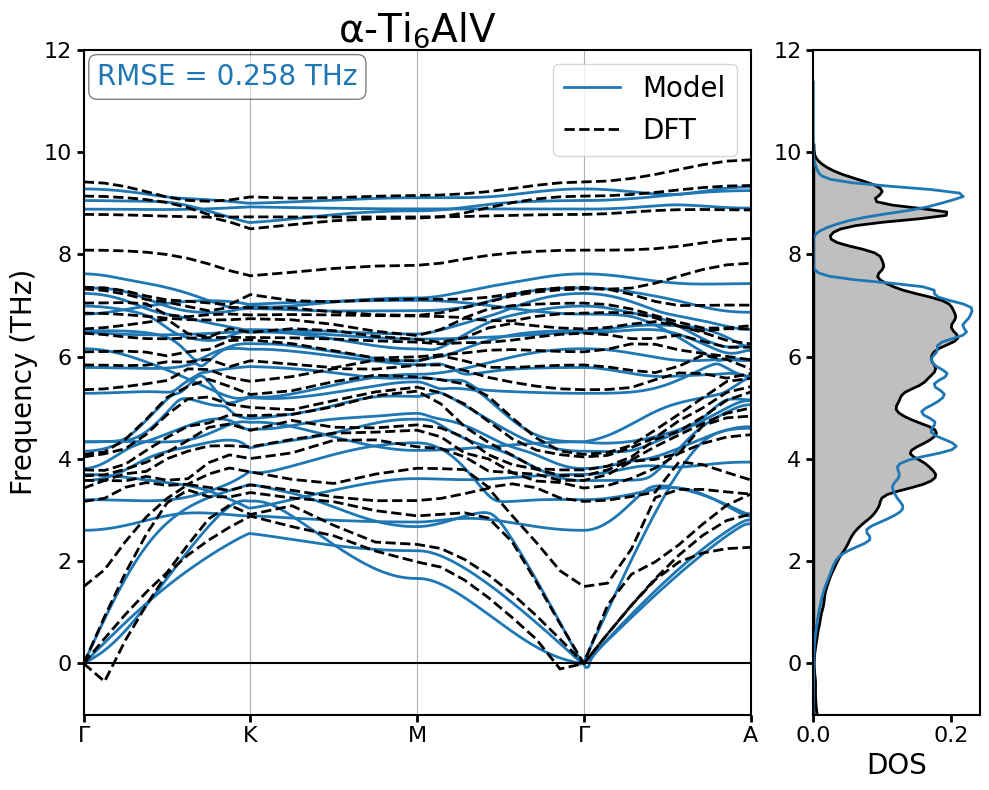

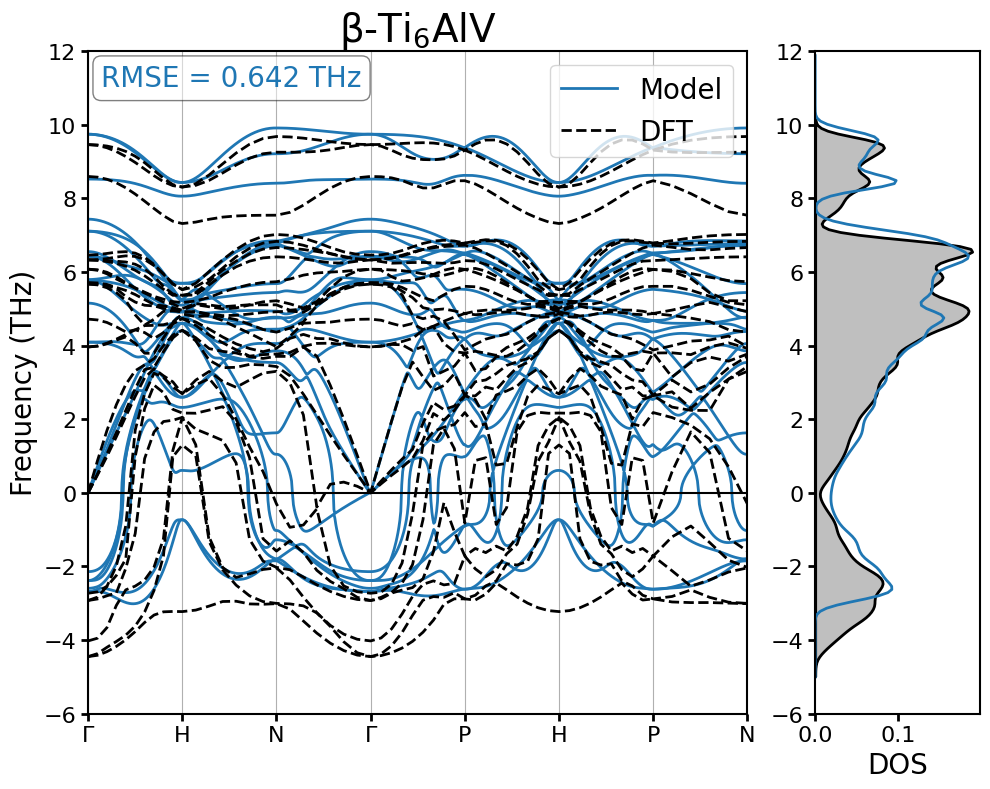

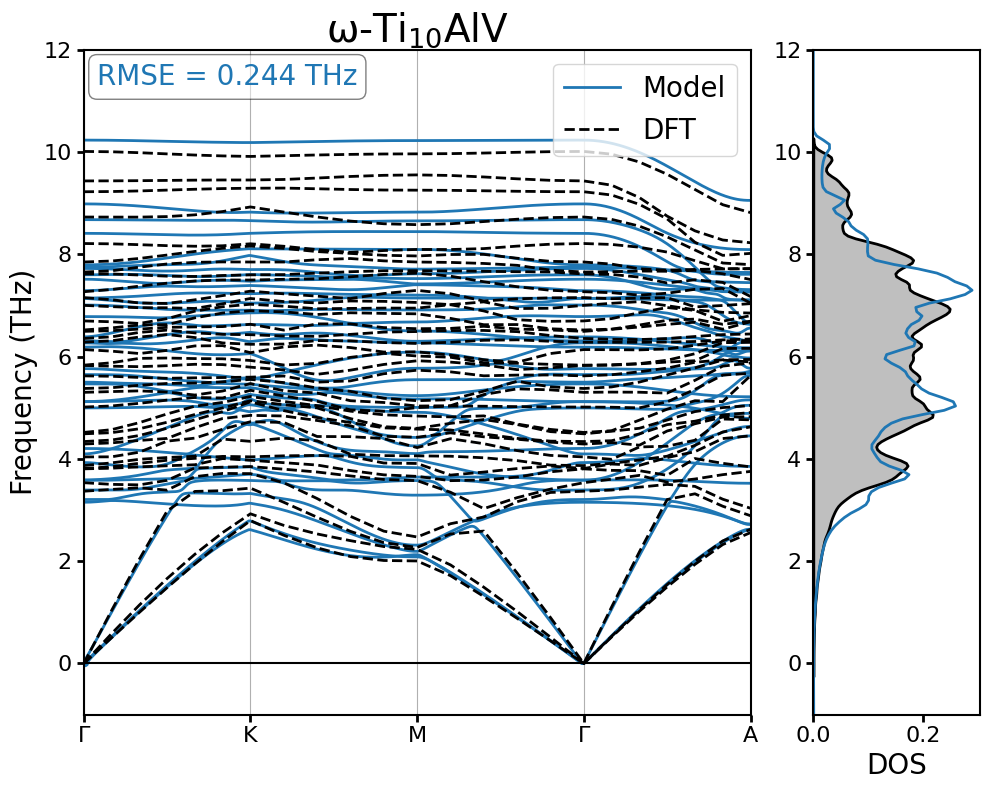

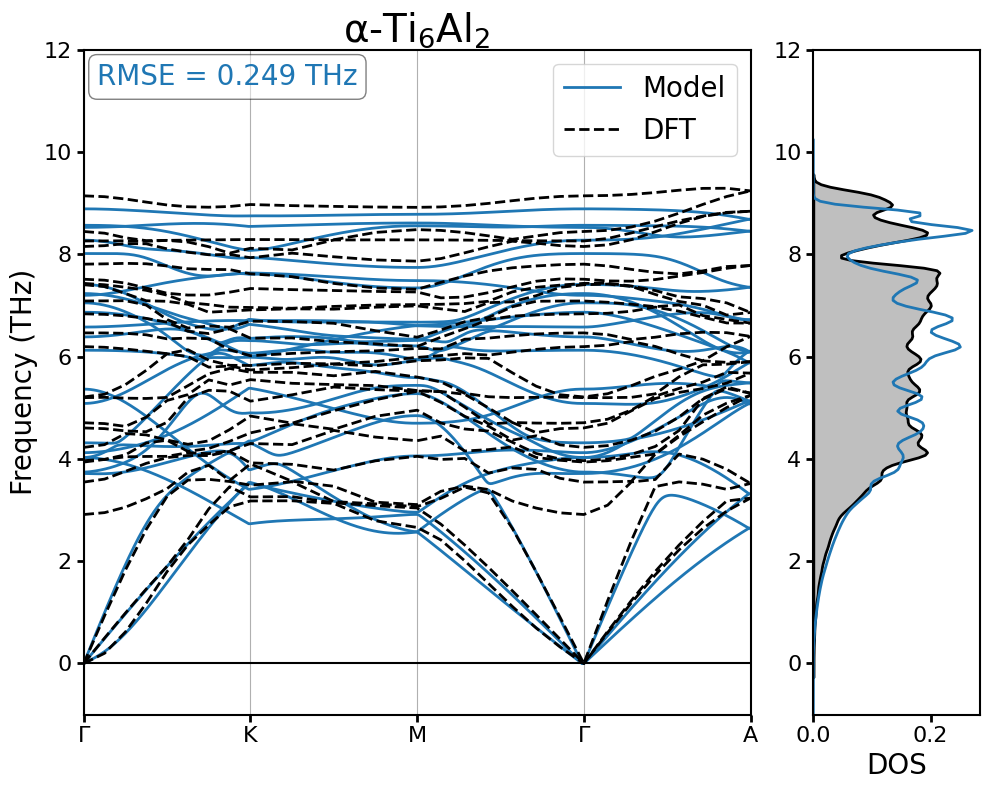

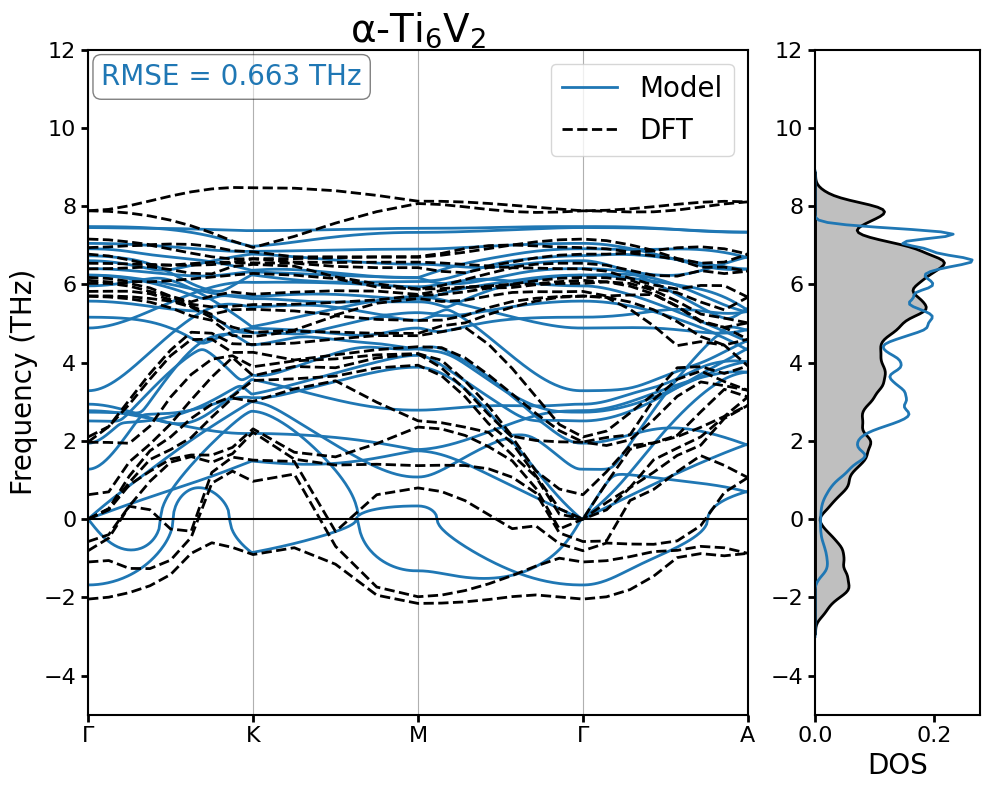

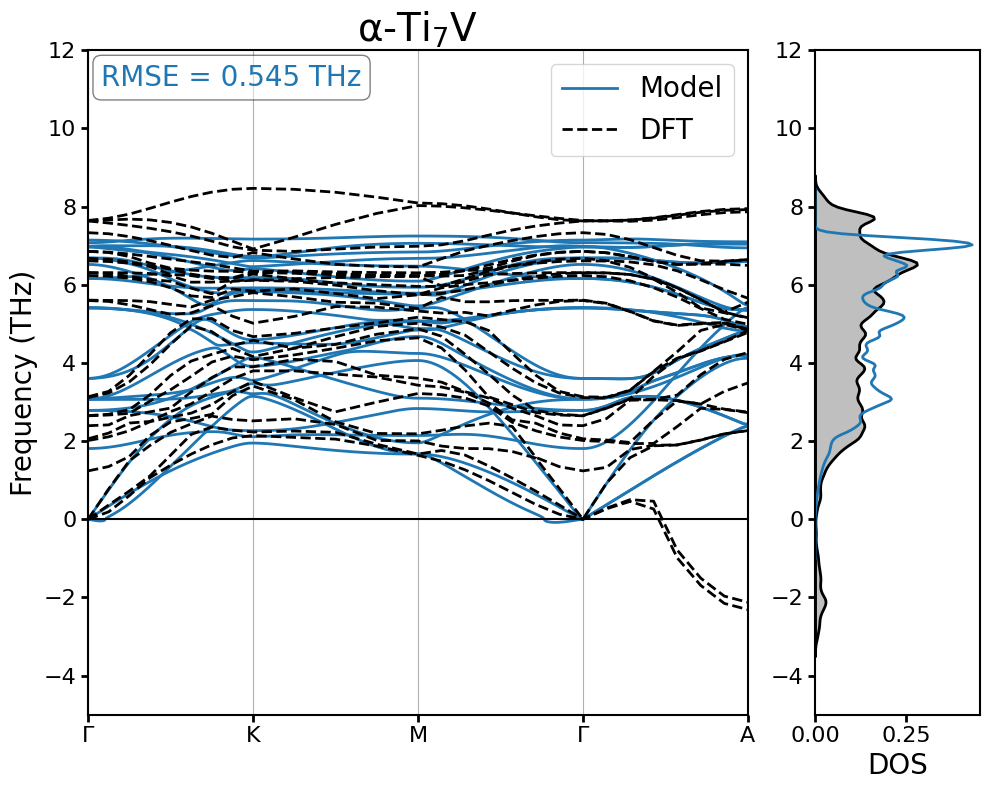

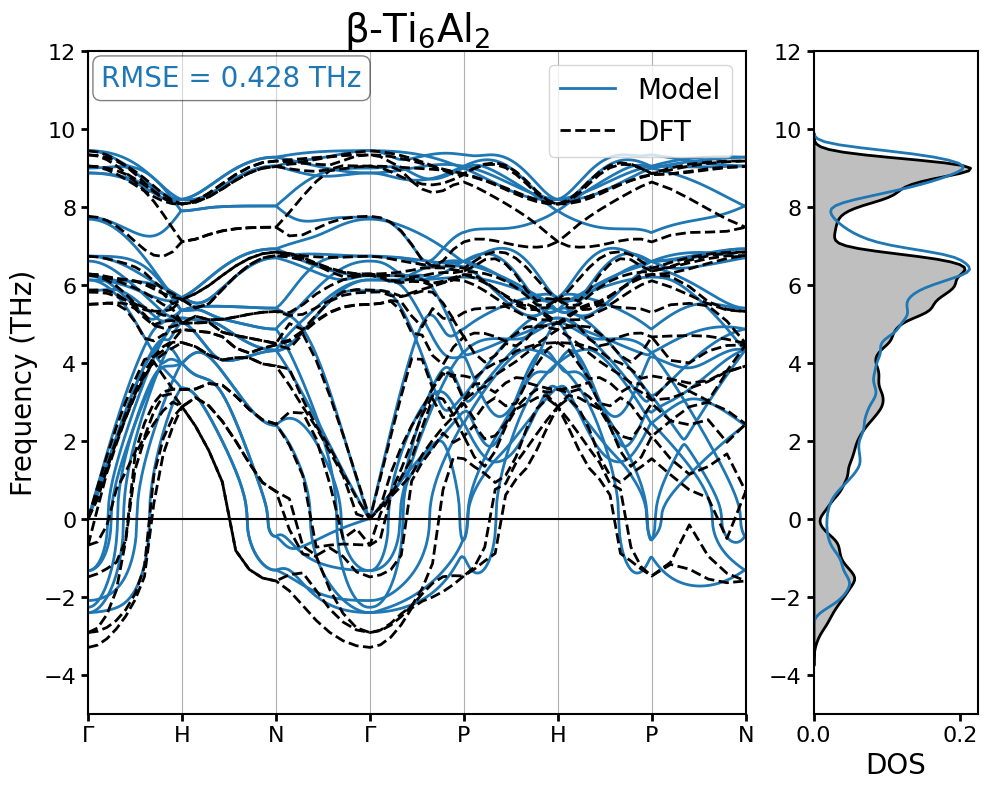

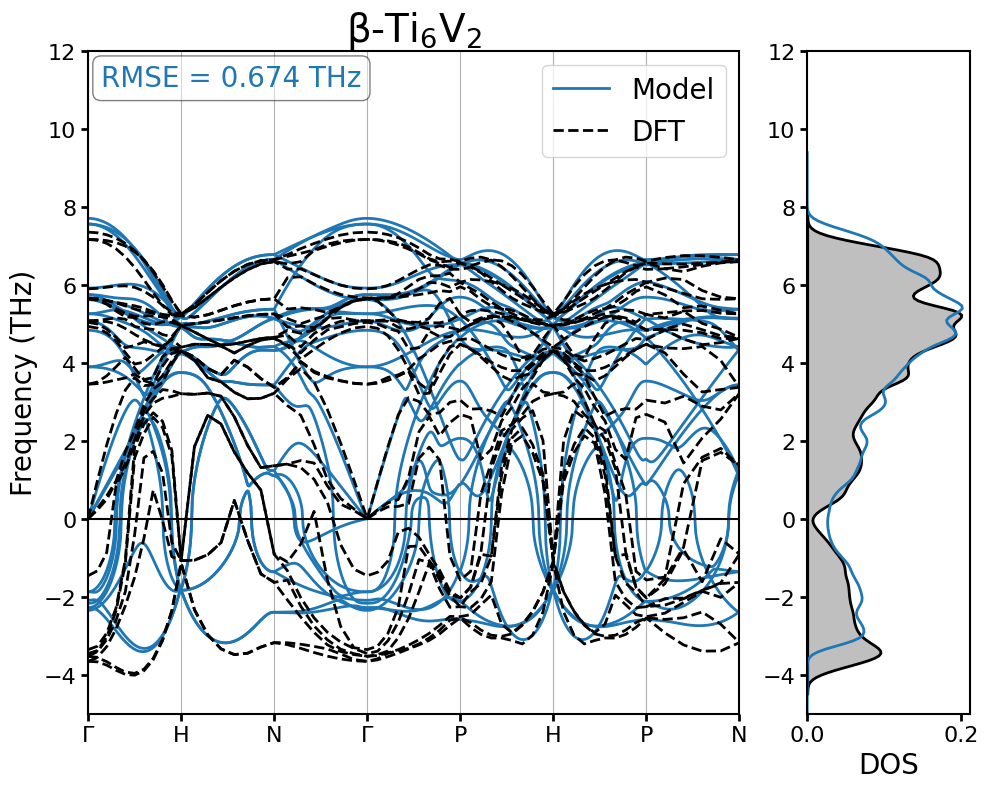

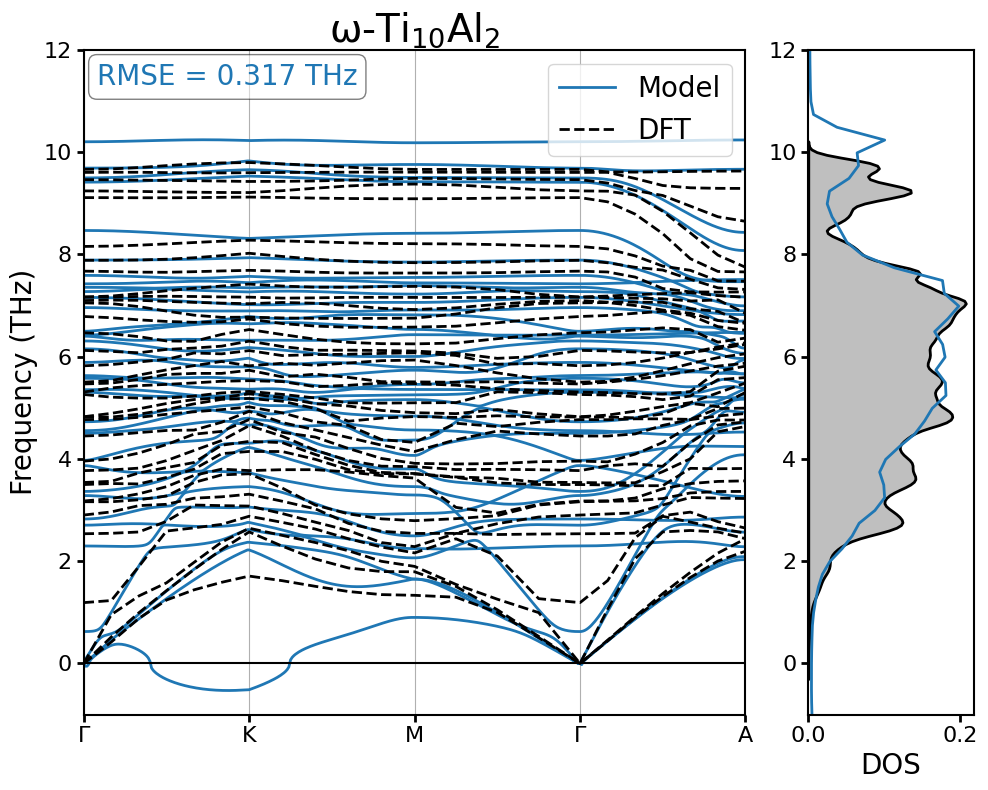

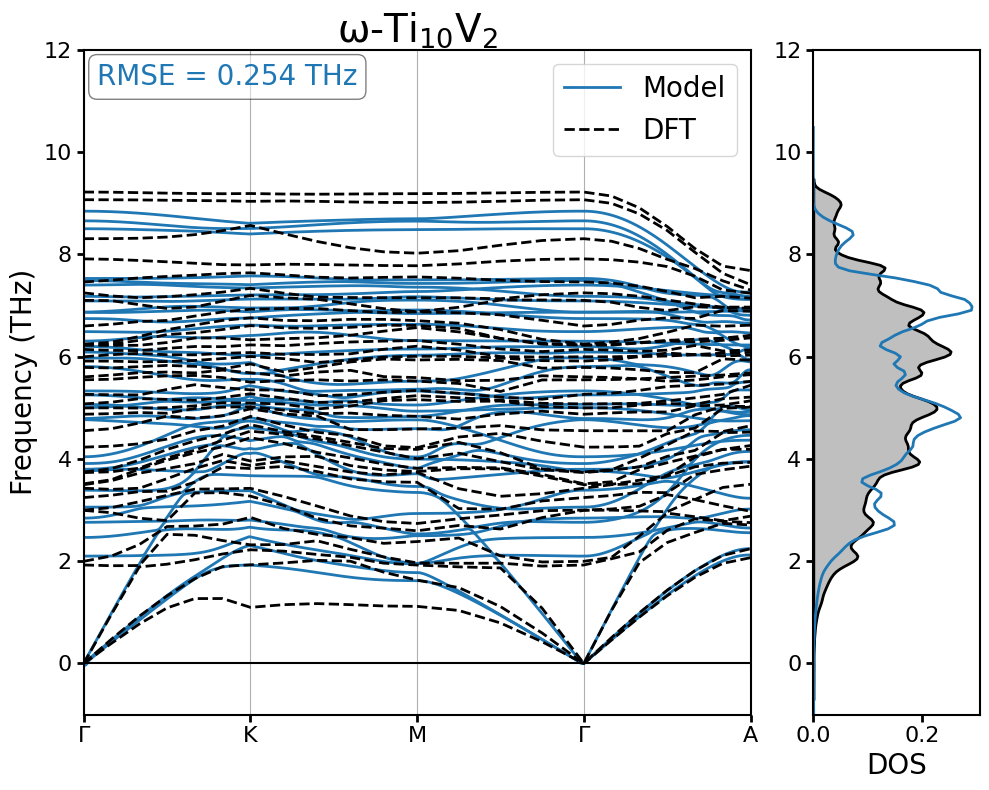

In [38]:
fmax=0.001; steps=10000
### hcp Ti6AlV
print("hcp Ti6AlV: 1/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hcp_phonon.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]
atoms=ase.io.read("data_and_benchmarks/ti64_hcp_phonon.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)

atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])

fileqponts= "data_and_benchmarks/ti64_hcp_phonon_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hcp_Ti7AlV (THz)'] = rmse
benchmarks_RMSE_all['hcp_Ti7AlV deltaF 0K (eV)'] = abs(fdft-fgap_alpha)[0]/N
benchmarks_RMSE_all['hcp_Ti7AlV deltaF 2000K (eV)'] = abs(fdft-fgap_alpha)[-1]/N




################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\alpha}$-Ti$_{6}$AlV', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-1,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()










### bcc Ti6VAl
print("bcc Ti6AlV: 2/10")
GAM=[0, 0, 0]
H=[0.5,-0.5,0.5]
P=[0.25,0.25,0.25]
N=[0,0,0.5]
path = [[GAM, H, N, GAM, P, H, P, N]]
labels = ["$\\Gamma$", "H", "N", "$\\Gamma$", "P", "H", "P", "N"]
file = "data_and_benchmarks/ti64_bcc_phonon.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
fileqponts= "data_and_benchmarks/ti64_bcc_phonon_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]
atoms=ase.io.read("data_and_benchmarks/ti64_bcc_phonon.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['bcc_Ti7AlV (THz)'] = rmse

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\beta}$-Ti$_{6}$AlV', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-6,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()







### hex Ti8AlV
print("hex Ti8AlV: 3/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hex_phonon.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/ti64_hex_phonon.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)

atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.01, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])

fileqponts= "data_and_benchmarks/ti64_hex_phonon_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hex_Ti10AlV (THz)'] = rmse
benchmarks_RMSE_all['hex_Ti10AlV deltaF 0K (eV)'] = abs(fdft-fgap_alpha)[0]/N
benchmarks_RMSE_all['hex_Ti10AlV deltaF 2000K (eV)'] = abs(fdft-fgap_alpha)[-1]/N

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\omega}$-Ti$_{10}$AlV', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-1,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()







### hcp Ti6Al2
print("hcp Ti6Al2: 4/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hcp_phonon_AlAl_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]
atoms=ase.io.read("data_and_benchmarks/ti64_hcp_phonon_AlAl_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
fileqponts= "data_and_benchmarks/ti64_hcp_phonon_AlAl_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hcp_Ti6Al2 (THz)'] = rmse
benchmarks_RMSE_all['hcp_Ti6Al2 deltaF 0K (eV)'] = abs(fdft-fgap_alpha)[0]/N
benchmarks_RMSE_all['hcp_Ti6Al2 deltaF 2000K (eV)'] = abs(fdft-fgap_alpha)[-1]/N


################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\alpha}$-Ti$_{6}$Al$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-1,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()





### hcp Ti6V2
print("hcp Ti6V2: 5/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hcp_phonon_VV_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]
atoms=ase.io.read("data_and_benchmarks/ti64_hcp_phonon_VV_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
fileqponts= "data_and_benchmarks/ti64_hcp_phonon_VV_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hcp_Ti6V2 (THz)'] = rmse
# benchmarks_RMSE_all['hcp_Ti6V2 deltaF 0K (eV)'] = (fdft-fgap_alpha)[0]/N
# benchmarks_RMSE_all['hcp_Ti6V2 deltaF 2000K (eV)'] = (fdft-fgap_alpha)[-1]/N

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\alpha}$-Ti$_{6}$V$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-5,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()


### hcp Ti7V
print("hcp Ti7V: 6/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/Ti7V_hcp_phonon_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/Ti7V_hcp_phonon_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
fileqponts= "data_and_benchmarks/Ti7V_hcp_phonon_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hcp_Ti7V (THz)'] = rmse
# benchmarks_RMSE_all['hcp_Ti6V2 deltaF 0K (eV)'] = (fdft-fgap_alpha)[0]/N
# benchmarks_RMSE_all['hcp_Ti6V2 deltaF 2000K (eV)'] = (fdft-fgap_alpha)[-1]/N

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\alpha}$-Ti$_{7}$V', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-5,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()










### bcc Ti6Al2
print("bcc Ti6Al2: 7/10")
GAM=[0, 0, 0]
H=[0.5,-0.5,0.5]
P=[0.25,0.25,0.25]
N=[0,0,0.5]
path = [[GAM, H, N, GAM, P, H, P, N]]
labels = ["$\\Gamma$", "H", "N", "$\\Gamma$", "P", "H", "P", "N"]
file = "data_and_benchmarks/ti64_bcc_phonon_AlAl_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/ti64_bcc_phonon_AlAl_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['bcc_Ti6Al2 (THz)'] = rmse
fileqponts= "data_and_benchmarks/ti64_bcc_phonon_AlAl_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')


################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\beta}$-Ti$_{6}$Al$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-5,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()







### bcc Ti6V2
print("bcc Ti6V2: 8/10")
GAM=[0, 0, 0]
H=[0.5,-0.5,0.5]
P=[0.25,0.25,0.25]
N=[0,0,0.5]
path = [[GAM, H, N, GAM, P, H, P, N]]
labels = ["$\\Gamma$", "H", "N", "$\\Gamma$", "P", "H", "P", "N"]
file = "data_and_benchmarks/ti64_bcc_phonon_VV_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/ti64_bcc_phonon_VV_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['bcc_Ti6V2 (THz)'] = rmse
fileqponts= "data_and_benchmarks/ti64_bcc_phonon_VV_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\beta}$-Ti$_{6}$V$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-5,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()






### hex Ti10Al2
print("hex Ti10Al2: 9/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hex_phonon_AlAl_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/ti64_hex_phonon_AlAl_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
fileqponts= "data_and_benchmarks/ti64_hex_phonon_AlAl_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hex_Ti10Al2 (THz)'] = rmse
benchmarks_RMSE_all['hex_Ti10Al2 deltaF 0K (eV)'] = abs(fdft-fgap_alpha)[0]/N
benchmarks_RMSE_all['hex_Ti10Al2 deltaF 2000K (eV)'] = abs(fdft-fgap_alpha)[-1]/N

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\omega}$-Ti$_{10}$Al$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-1,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()





### hex Ti10Al2
print("hex Ti10Al2: 10/10")
GAM=[0, 0, 0]
A=[0,0,1/2]
K=[1/3, 1/3, 0]
M=[0.5,0,0]
path = [[GAM, K, M, GAM, A]]
labels = ["$\\Gamma$", "K", "M", "$\\Gamma$", "A"]
file = "data_and_benchmarks/ti64_hex_phonon_VV_qpath.castep"
pfc = PhononFromCastep(castep_file=file, kpath_in=path[0])
grid=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]

atoms=ase.io.read("data_and_benchmarks/ti64_hex_phonon_VV_qpath.castep")
atoms.calc=calc
dyn = LBFGS(atoms, logfile=None)
dyn.run(fmax=fmax, steps=steps)
atp_gap = AtomsToPhonons(primitive_cell=atoms, phonon_grid=grid, displacement=0.02, kpath=path, calculator=calc, plusminus=True)
atp_gapPDOS = AtomsToPDOS(primitive_cell=atoms, phonon_grid=grid,
                          displacement=0.02, calculator=calc)
atp_gapPDOS.get_PDOS([20,20,20])
atp_gapPDOS.get_DOS([20,20,20])
fileqponts= "data_and_benchmarks/ti64_hex_phonon_VV_qpoints.castep"
qpointatoms=ase.io.read(fileqponts)
pfcPDOS = PhononFromCastepPDOS(castep_file=fileqponts, atoms_in=qpointatoms)
weights = np.tile(pfcPDOS.weights , (np.shape(pfcPDOS.frequencies)[1],1)) .flatten(order='F')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
N=len(atoms)
T = np.linspace(0,2000, 2000)
hfe_dft=[]
for t in T:
    hfe_dft.append(helmoholtz_free_energy(weights, pfcPDOS.frequencies,t) + zp_energy(pfcPDOS.frequencies.flatten(), weights))
hfe_dft=np.array(hfe_dft)
hfe_dft_alpha=hfe_dft
atp_gapPDOS.get_tp([20,20,20], tmax=2000, tstep=1)
txx, fdft, fgap_alpha = interpolate(T,hfe_dft, atp_gapPDOS.tp_dict['temperatures'], atp_gapPDOS.tp_dict['free_energy'] / 96.32 )

rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
benchmarks_RMSE_all['hex_Ti10V2 (THz)'] = rmse
benchmarks_RMSE_all['hex_Ti10V2 deltaF 0K (eV)'] = abs(fdft-fgap_alpha)[0]/N
benchmarks_RMSE_all['hex_Ti10V2 deltaF 2000K (eV)'] = abs(fdft-fgap_alpha)[-1]/N

################
### Plotting ###
################
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[10,8])
a0.plot(atp_gap.frequencies[:,:], color='C0', label='Model', linewidth=2)
a0.plot(pfc.xscale*100*(len(path[0])-1), pfc.frequencies[:,:], 'k--', label= 'DFT', linewidth=2)
rmse = np.sqrt(sum(get_error(atp_gap, pfc).flatten()**2)/len(get_error(atp_gap, pfc).flatten()))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
a0.text(0.02, 0.98, f'RMSE = {rmse:.3f} THz', transform=a0.transAxes, fontsize=20,
        verticalalignment='top', bbox=props, color='C0')
dftphonon={}
dftphonon[''] = pfcPDOS.frequencies.flatten()
kdeplot(data=dftphonon,weights=weights, y='', ax=a1, color='k',bw=0.05, label='DFT', fill=True, linewidth=2)
AREA= np.trapz(np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0), 
               dx=abs(atp_gapPDOS.pdos['frequency_points'][1]-atp_gapPDOS.pdos['frequency_points'][0]))
dftphonon={}
dftphonon[''] = atp_gapPDOS.pdos['frequency_points']
GAPPDOS=np.sum(atp_gapPDOS.pdos['projected_dos'], axis=0)/atp_gapPDOS.pdos['projected_dos'].shape[0]
kdeplot(data=dftphonon,weights=GAPPDOS/AREA, y='', ax=a1, color='C0',bw=0.05, label='GAP', fill=False, linewidth=2)
plt.sca(a0)
plt.xticks(atp_gap.normal_ticks, labels)
a0.set_title(r'$\rm{\omega}$-Ti$_{10}$V$_{2}$', fontsize=28)
a0.set_ylabel('Frequency (THz)', fontsize=20)
a0.set_xlim(atp_gap.normal_ticks[0], atp_gap.normal_ticks[-1])
a0.grid(axis='x')
a0.axhline(y=0, ls='-', color='k')
handles, labelsw = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labelsw, handles))
a0.legend(by_label.values(), by_label.keys(), loc=1, fontsize=20)
a1.set_ylim([-1,12])
a0.tick_params(labelsize=16, size=5, width=2)
a1.tick_params(labelsize=16, size=5, width=2)
a1.set_xlabel('DOS', fontsize=20)
a0.set_ylim(a1.get_ylim())
f.tight_layout()





In [39]:
testend=time.time()
print(f"{(testend-teststart)/60} minutes")

14.474284458160401 minutes


## Elastic Constants

In [40]:
import ase
import ase.build
import os
import numpy as np
from ase.calculators.castep import Castep
import warnings
warnings.simplefilter('ignore')
from glob import glob
import matscipy.elasticity as mat
from concurrent.futures import ProcessPoolExecutor
from ase.constraints import ExpCellFilter
from contextlib import redirect_stdout
import io
from ase.optimize import LBFGS
def parse_lines(ml):
    EC={}
    for l in ml:
        if float(l.split()[2]) > -50.0:
            EC[l.split()[0]]=float(l.split()[2])
    return EC
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5

# Calculate B for Hexagonal, Tetragonal & Trigonal
# DOI: 10.1103/PhysRevB.77.104118 Eq. (29)
def HTT_B(c11, c33, c12, c13):
    numerator   = c33 * (c11 + c12) - 2*c13**2
    denominator = c11 + c12 + 2*c33 - 4*c13

    return numerator / denominator

# Mater Trans v 53 p 1247 (2012), Eq. 4-10
def VRH_B(c11, c33, c12, c13, c44, c66):
    Bv = (1.0/9.0)*(2.0*(c11+c12) + c33 + 4.0*c13)

    M = c11 + c12 + 2.0*c33 - 4.0*c13
    Csq = (c11+c12)*c33 - 2.0*c13**2
    Br = Csq/M

    return (Bv+Br)/2.0

def cubic_B(c11,c12):
    return (c11+2.0*c12)/3.0


def optimise_geom(atoms):
    atoms.calc=pot
    ecf = ExpCellFilter(atoms, hydrostatic_strain=True)
    dyn = LBFGS(ecf)
    dyn.run(0.0001);
    return atoms.copy()

def RMSE(model,ref):
    N=len(model)
    num = (ref-model)**2
    return np.sqrt(sum(num)/N)
e0={'Al':-107.1308,'Ti':-1587.0235,'V':-2065.7874}

In [41]:
prim_cell = ase.io.read('data_and_benchmarks/sqs_bcc_sc4x4x4_Ti55Al7V2_frame0_geomopti.castep')
all_configs = []
strain_array=[]
for s in mat.generate_strained_configs(prim_cell,  delta=0.01, N_steps=5, symmetry='cubic'):
    all_configs.append(s)
    strain_array.append(s.info['strain'])


atoms_singlepoint = [ase.io.read(a) for a in np.sort(glob('data_and_benchmarks/strained_frame0/*bcc*.castep'))]
for a,s in zip(atoms_singlepoint, strain_array):
    a.info['strain'] = s

f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(atoms_singlepoint, delta=0.01, N_steps=5,symmetry='cubic')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
dft_bcc = parse_lines(matched_lines)
dft_bcc['B'] = cubic_B(dft_bcc['C_11'], dft_bcc['C_12'])





temp_all=[]
for a in atoms_singlepoint:
    temp = a.copy()
    temp.calc=calc
    temp_all.append(temp)

f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(temp_all, delta=0.01, N_steps=5,symmetry='cubic')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
gap_bcc = parse_lines(matched_lines)
gap_bcc['B'] = cubic_B(gap_bcc['C_11'], gap_bcc['C_12'])



prim_cell = ase.io.read('data_and_benchmarks/sqs_hcp_sc3x3x3_Ti46Al6V2_frame0_geomopti.castep')
all_configs = []
strain_array=[]
for s in mat.generate_strained_configs(prim_cell,  delta=0.01, N_steps=5, symmetry='trigonal_high'):
    all_configs.append(s)
    strain_array.append(s.info['strain'])

atoms_singlepoint = [ase.io.read(a) for a in np.sort(glob('data_and_benchmarks/strained_frame0/*hcp*.castep'))]
for a,s in zip(atoms_singlepoint, strain_array):
    a.info['strain'] = s
f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(atoms_singlepoint, delta=0.01, N_steps=5,symmetry='trigonal_high')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
dft_hcp = parse_lines(matched_lines)
dft_hcp['B'] = HTT_B(dft_hcp['C_11'],dft_hcp['C_33'], dft_hcp['C_12'], dft_hcp['C_13'])



temp_all=[]

for a in all_configs:
    temp = a.copy()
    temp.calc=calc
    # dyn = LBFGS(temp)
    # dyn.run(fmax=0.0001) #relax
    temp_all.append(temp)

f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(temp_all, delta=0.01, N_steps=5,symmetry='trigonal_high')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
gap_hcp = parse_lines(matched_lines)
gap_hcp['B'] = HTT_B(gap_hcp['C_11'],gap_hcp['C_33'], gap_hcp['C_12'], gap_hcp['C_13'])



prim_cell = ase.io.read('data_and_benchmarks/sqs_hex_sc3x3x3_Ti70Al8V3_frame0_geomopti.castep')
all_configs = []
strain_array=[]
for s in mat.generate_strained_configs(prim_cell,  delta=0.01, N_steps=5, symmetry='trigonal_high'):
    all_configs.append(s)
    strain_array.append(s.info['strain'])


atoms_singlepoint = [ase.io.read(a) for a in np.sort(glob('data_and_benchmarks/strained_frame0/*hex*.castep'))]
for a,s in zip(atoms_singlepoint, strain_array):
    a.info['strain'] = s

f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(atoms_singlepoint, delta=0.01, N_steps=5,symmetry='trigonal_high')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
dft_hex = parse_lines(matched_lines)
dft_hex['B'] = HTT_B(dft_hex['C_11'],dft_hex['C_33'], dft_hex['C_12'], dft_hex['C_13'])




temp_all=[]

for a in all_configs:
    temp = a.copy()
    temp.calc=calc
    # dyn = LBFGS(temp)
    # dyn.run(fmax=0.0001) #relax
    temp_all.append(temp)

f = io.StringIO()
with redirect_stdout(f):
    mat.fit_elastic_constants(temp_all, delta=0.01, N_steps=5,symmetry='trigonal_high')
out = f.getvalue()
matched_lines=[]
for line in out.split('\n'):
    if "C_" in line and "=" in line:
        matched_lines.append(line)
gap_hex = parse_lines(matched_lines)
gap_hex['B'] = HTT_B(gap_hex['C_11'],gap_hex['C_33'], gap_hex['C_12'], gap_hex['C_13'])





In [42]:
# gap_bcc
# dft_bcc
# [gap_bcc[a] for a in gap_bcc]
# print(get_RMSE(np.array([gap_bcc[a] for a in gap_bcc]), np.array([dft_bcc[a] for a in dft_bcc])))
# print(get_RMSE(np.array([gap_hcp[a] for a in gap_hcp]), np.array([dft_hcp[a] for a in dft_hcp])))
# print(get_RMSE(np.array([gap_hex[a] for a in gap_hex]), np.array([dft_hex[a] for a in dft_hex])))

benchmarks_RMSE_all['bcc_C11 (GPa)'] = abs(dft_bcc['C_11'] - gap_bcc['C_11'])
benchmarks_RMSE_all['bcc_C12 (GPa)'] = abs(dft_bcc['C_12'] - gap_bcc['C_12'])
benchmarks_RMSE_all['bcc_C44 (GPa)'] = abs(dft_bcc['C_44'] - gap_bcc['C_44'])
benchmarks_RMSE_all['bcc_B (GPa)'] = abs(dft_bcc['B'] - gap_bcc['B'])
benchmarks_RMSE_all['bcc_EC_RMSE (GPa)'] = get_RMSE(np.array([gap_bcc[a] for a in gap_bcc]), np.array([dft_bcc[a] for a in dft_bcc]))


benchmarks_RMSE_all['hcp_C11 (GPa)'] = abs(dft_hcp['C_11'] - gap_hcp['C_11'])
benchmarks_RMSE_all['hcp_C12 (GPa)'] = abs(dft_hcp['C_12'] - gap_hcp['C_12'])
benchmarks_RMSE_all['hcp_C13 (GPa)'] = abs(dft_hcp['C_13'] - gap_hcp['C_13'])
benchmarks_RMSE_all['hcp_C14 (GPa)'] = abs(dft_hcp['C_14'] - gap_hcp['C_14'])
benchmarks_RMSE_all['hcp_C15 (GPa)'] = abs(dft_hcp['C_15'] - gap_hcp['C_15'])
benchmarks_RMSE_all['hcp_C33 (GPa)'] = abs(dft_hcp['C_33'] - gap_hcp['C_33'])
benchmarks_RMSE_all['hcp_C44 (GPa)'] = abs(dft_hcp['C_44'] - gap_hcp['C_44'])
benchmarks_RMSE_all['hcp_C66 (GPa)'] = abs(dft_hcp['C_66'] - gap_hcp['C_66'])
benchmarks_RMSE_all['hcp_B (GPa)'] = abs(dft_hcp['B'] - gap_hcp['B'])
benchmarks_RMSE_all['hcp_EC_RMSE (GPa)'] = get_RMSE(np.array([gap_hcp[a] for a in gap_hcp]), np.array([dft_hcp[a] for a in dft_hcp]))


benchmarks_RMSE_all['hex_C11 (GPa)'] = abs(dft_hex['C_11'] - gap_hex['C_11'])
benchmarks_RMSE_all['hex_C12 (GPa)'] = abs(dft_hex['C_12'] - gap_hex['C_12'])
benchmarks_RMSE_all['hex_C13 (GPa)'] = abs(dft_hex['C_13'] - gap_hex['C_13'])
benchmarks_RMSE_all['hex_C14 (GPa)'] = abs(dft_hex['C_14'] - gap_hex['C_14'])
benchmarks_RMSE_all['hex_C15 (GPa)'] = abs(dft_hex['C_15'] - gap_hex['C_15'])
benchmarks_RMSE_all['hex_C33 (GPa)'] = abs(dft_hex['C_33'] - gap_hex['C_33'])
benchmarks_RMSE_all['hex_C44 (GPa)'] = abs(dft_hex['C_44'] - gap_hex['C_44'])
benchmarks_RMSE_all['hex_C66 (GPa)'] = abs(dft_hex['C_66'] - gap_hex['C_66'])
benchmarks_RMSE_all['hex_B (GPa)'] = abs(dft_hex['B'] - gap_hex['B'])
benchmarks_RMSE_all['hex_EC_RMSE (GPa)'] = get_RMSE(np.array([gap_hex[a] for a in gap_hex]), np.array([dft_hex[a] for a in dft_hex]))

## Write out all RMSE

In [43]:
benchmarks_RMSE_all
RMSE_loc=f"RMSE_benchmarks/{RMSEname}"
with open(RMSE_loc, 'w') as f:
    json.dump(benchmarks_RMSE_all, f)
print(RMSE_loc)

RMSE_benchmarks/RMSE_all_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json


# Read In
This is for plotting big tables of all errors

In [25]:
RMSE_loc=f"RMSE_benchmarks/RMSE_all_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json"
obj_text = codecs.open(RMSE_loc, 'r', encoding='utf-8').read()
RMSEallread0 = json.loads(obj_text)
RMSEallread0.keys()

dict_keys(['E_train (eV)', 'F_train (eV/AA)', 'V_train (eV)', 'hcp_Ti7AlV (THz)', 'hcp_Ti7AlV deltaF 0K (eV)', 'hcp_Ti7AlV deltaF 2000K (eV)', 'bcc_Ti7AlV (THz)', 'hex_Ti10AlV (THz)', 'hex_Ti10AlV deltaF 0K (eV)', 'hex_Ti10AlV deltaF 2000K (eV)', 'hcp_Ti6Al2 (THz)', 'hcp_Ti6Al2 deltaF 0K (eV)', 'hcp_Ti6Al2 deltaF 2000K (eV)', 'hcp_Ti6V2 (THz)', 'hcp_Ti7V (THz)', 'bcc_Ti6Al2 (THz)', 'bcc_Ti6V2 (THz)', 'hex_Ti10Al2 (THz)', 'hex_Ti10Al2 deltaF 0K (eV)', 'hex_Ti10Al2 deltaF 2000K (eV)', 'hex_Ti10V2 (THz)', 'hex_Ti10V2 deltaF 0K (eV)', 'hex_Ti10V2 deltaF 2000K (eV)', 'bcc_C11 (GPa)', 'bcc_C12 (GPa)', 'bcc_C44 (GPa)', 'bcc_B (GPa)', 'bcc_EC_RMSE (GPa)', 'hcp_C11 (GPa)', 'hcp_C12 (GPa)', 'hcp_C13 (GPa)', 'hcp_C14 (GPa)', 'hcp_C15 (GPa)', 'hcp_C33 (GPa)', 'hcp_C44 (GPa)', 'hcp_C66 (GPa)', 'hcp_B (GPa)', 'hcp_EC_RMSE (GPa)', 'hex_C11 (GPa)', 'hex_C12 (GPa)', 'hex_C13 (GPa)', 'hex_C14 (GPa)', 'hex_C15 (GPa)', 'hex_C33 (GPa)', 'hex_C44 (GPa)', 'hex_C66 (GPa)', 'hex_B (GPa)', 'hex_EC_RMSE (GPa)'])

In [46]:
import codecs, json
def get_averaged_metric(json):
    phonons = np.array([json[k]for k in json.keys() if 'THz' in k])
    EC_RMSE = np.array([json[k] for k in json.keys() if 'EC_RMSE' in k])
    json['Mean Phonon RMSE (THz)'] = phonons.mean()
    json['Mean EC RMSE (GPa)'] = EC_RMSE.mean()
    filtered={}
    filtered['E_train (eV)'] = json['E_train (eV)']
    filtered['F_train (eV/AA)'] = json['F_train (eV/AA)']
    filtered['V_train (eV)'] = json['V_train (eV)']
    filtered['E_validation (eV)'] = json['E_validation (eV)']
    filtered['F_validation (eV/AA)'] = json['F_validation (eV/AA)']
    filtered['V_validation (eV)'] = json['V_validation (eV)']
    filtered['Mean Phonon RMSE (THz)'] = json['Mean Phonon RMSE (THz)']
    filtered['Mean EC RMSE (GPa)'] = json['Mean EC RMSE (GPa)']
    return filtered


In [47]:
### Make a list of all the different models you want to compare in the table below. NOTE these are the RMSE_all_*.json files. 
RMSE_loc=[
          f"RMSE_benchmarks/RMSE_all_ti64_combined_data_Apr08_rcut_6.0_order_3_degree_15_custom_reg.json",
          ]





RMSEallread_array=[]
for r in RMSE_loc:
    obj_text = codecs.open(r, 'r', encoding='utf-8').read()
    RMSEallread0 = json.loads(obj_text)
    RMSEallread0f=get_averaged_metric(RMSEallread0)
    RMSEallread_array.append(np.array([RMSEallread0[a] for a in RMSEallread0]))
RMSEallread_array=np.array(RMSEallread_array)

def zero_to_one(y):
    #y=mx+c
    c = y.min()
    m = y.max()-c
    return 1-(y-c)/m

normed=[]
FOM=[]
for d in RMSEallread_array.T:
    normed.append(zero_to_one(d))
normed=np.array(normed)
for n in normed.T:
    FOM.append(n.mean())
FOM = np.array(FOM)



A=np.append(RMSEallread_array.T, np.array([FOM]), axis=0)
RMSEallread_array=A.T
RMSEallread0['FOM'] = FOM[0]

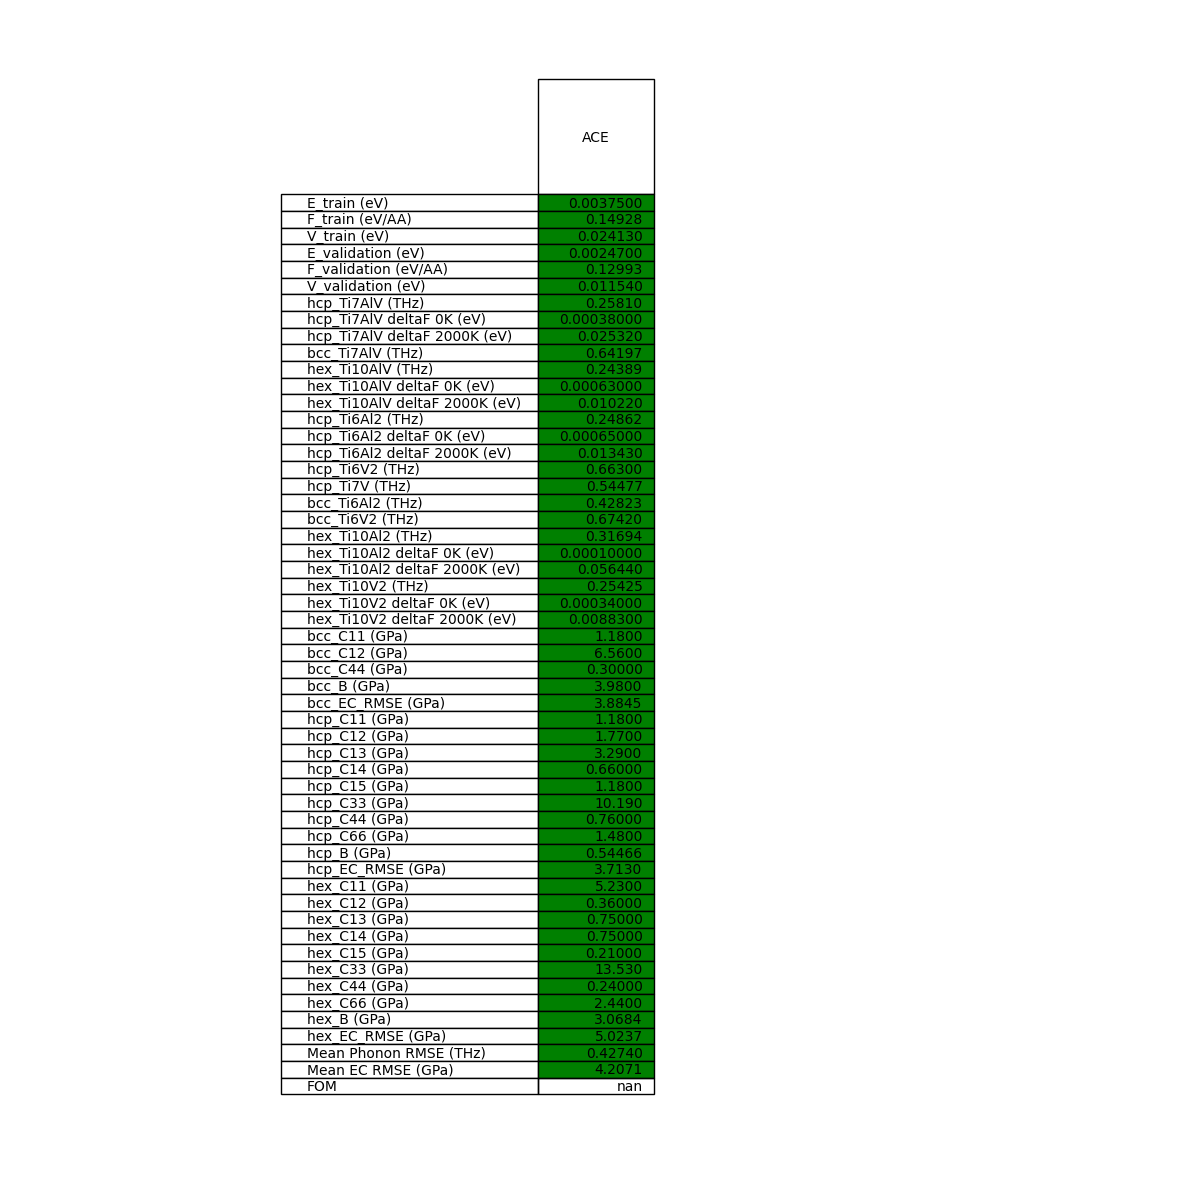

In [48]:
# RMSEallreadTwo
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0
from pandas import *
from  matplotlib.colors import LinearSegmentedColormap
cmapcust=LinearSegmentedColormap.from_list('rg',[ "g", "y", "r"], N=256) 

# labels for models -- make sure this is as long as your RMSE_all*.json list.
cols=['ACE',
      # 'MACE 2',
      # 'MACE 5',
      # 'MACE 10',
      # 'MACE 20',
      # 'MACE 40',
      # 'MACE 60',
      # 'MACE 80',
      # 'MACE 100',
      ]

idx = Index(np.arange(1,len(RMSEallread0.keys())+1))
df = DataFrame(RMSEallread_array.T, index=RMSEallread0.keys(), columns=cols)
vals2 = np.around(df.values,5)
vals=np.array([[np.format_float_positional(x, precision=5, trim='k') for x in y] for y in df.values], dtype=float)



norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours=[]
for v in vals[0:-1]:
    norm = plt.Normalize(v.min()-0.00*(v.max()-v.min()), v.max()+0.00*(v.max()-v.min()))
    colours.append( cmapcust(norm(v)))

norm = plt.Normalize(vals[-1].min(), vals[-1].max())
colours.append( cmapcust(1-norm(vals[-1])))

colours=np.array(colours)



fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

rowheights = [0.15]*vals.shape[0]
rowheights[0]=0.3

vals=np.array([[f"{x:#.5g}" for x in y] for y in vals])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1],  
                    loc='center',
                    cellColours=colours)

cellDict = the_table.get_celld()



for i in range(len(RMSEallread_array)):
  cellDict[(0,i)].set_height(.1)


plt.show()


